In [1]:
import os
from Bio import SeqIO

In [2]:
def read_data():
    base_directory = './h_pylori_paidb//'
    data = {}
    
    for name in os.listdir(base_directory):
        dir_path = os.path.join(base_directory, name)

        if os.path.isdir(dir_path):
            fasta_file = os.path.join(dir_path, f"{name}.fasta")
            pai_file   = os.path.join(dir_path, f"{name}.pai")
            cpai_file  = os.path.join(dir_path, f"{name}.cpai")
            npai_file  = os.path.join(dir_path, f"{name}.npai")

            data[name] = {}
            genome_sequence = next(SeqIO.parse(fasta_file, 'fasta'))
            data[name]['genome_sequence'] = genome_sequence

            with open(pai_file, 'r') as file:
                data[name]['pai_sequences'] = []

                while True:
                    line = file.readline()
                    if not line:
                        break

                    line = line.split()
                    pai_start_index = int(line[0])
                    pai_end_index = int(line[1])

                    pai_sequence = genome_sequence.seq[pai_start_index:pai_end_index]

                    data[name]['pai_sequences'].append((pai_sequence, (pai_start_index, pai_end_index)))

            with open(cpai_file, 'r') as file:
                data[name]['cpai_sequences'] = []

                while True:
                    line = file.readline()
                    if not line:
                        break

                    line = line.split()
                    cpai_start_index = int(line[0])
                    cpai_end_index = int(line[1])

                    cpai_sequence = genome_sequence.seq[cpai_start_index:cpai_end_index]

                    data[name]['cpai_sequences'].append((cpai_sequence, (cpai_start_index, cpai_end_index)))

            with open(npai_file, 'r') as file:
                data[name]['npai_sequences'] = []

                while True:
                    line = file.readline()
                    if not line:
                        break

                    line = line.split()
                    npai_start_index = int(line[0])
                    npai_end_index = int(line[1])

                    npai_sequence = genome_sequence.seq[npai_start_index:npai_end_index]

                    data[name]['npai_sequences'].append((npai_sequence, (npai_start_index, npai_end_index)))

    return data

In [3]:
h_pylori_data = read_data()

### TF-IDF

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(sequence, k):
    kmers = get_kmers(str(sequence), k)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform([kmers])
    tfidf_matrix = X.toarray()
    return tfidf_matrix, vectorizer

def get_kmers(sequence, k):
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    return ' '.join(kmers)

def get_kmers_map(tfidf_matrix, vectorizer, sequence, top_n=20):
    feature_names = vectorizer.get_feature_names_out()
    feature_scores = tfidf_matrix.flatten()
    
    top_kmers_indices = feature_scores.argsort()[-top_n:][::-1]
    top_kmers = [(feature_names[i], feature_scores[i]) for i in top_kmers_indices]

    mapped_kmers = {}
    for kmer, score in top_kmers:
        kmer = kmer.upper()
        count = sequence.count(kmer)
        mapped_kmers[kmer] = {'score': score, 'count': count}
        
    return mapped_kmers

def find_unique_kmers(full_sequence, start_index, end_index, significant_kmers, unique_kmers):
    for kmer, details in significant_kmers.items():
        left_occurrences = full_sequence[:start_index].count(kmer)
        right_occurrences = full_sequence[end_index:].count(kmer)
        occurrences = left_occurrences + right_occurrences
        if occurrences == 0:
            unique_kmers.append((kmer, details['count']))

In [5]:
def get_unique_patterns(full_sequence, island_sequence, start_index, end_index, k_max):
    
    unique_kmers = []
    
    for k in range(4, k_max):
        tfidf_matrix, vectorizer = tfidf(island_sequence, k)
        kmers = get_kmers_map(tfidf_matrix, vectorizer, island_sequence)
        find_unique_kmers(full_sequence, start_index, end_index, kmers, unique_kmers)
        
    return unique_kmers

In [6]:
import logging

logging.basicConfig(filename='./logs/tfidf_all_islands.log', level=logging.INFO,
                    format='%(message)s')

console = logging.StreamHandler()
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter('%(message)s'))

logging.getLogger('').addHandler(console)

In [6]:
from Bio import Align
from Bio.Seq import Seq

In [7]:
def count_matches(sequence, pattern):
    aligner = Align.PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 2
    aligner.mismatch_score = -2
    aligner.open_gap_score = -2
    aligner.extend_gap_score = -1
    
    alignments = aligner.align(sequence, pattern)
    threshold = 0.85 * (2 * len(pattern))
    
    return sum(1 for alignment in alignments if alignment.score >= threshold)

In [8]:
def find_islands_kmers(full_sequence,
                       pai_islands,
                       cpai_islands,
                       npai_islands,
                       significant_kmers,
                       all_islands_kmers):
    
    all_islands = pai_islands + cpai_islands + npai_islands
    all_islands.sort(key=lambda x: x[0])
        
    for kmer, details in significant_kmers.items():
        
        if kmer in all_islands_kmers:
            continue
        
        start = 0
        end = 0
        isUnique = True
        
        # Check if kmer doesn't exist outside of the islands
        for island in all_islands:
            end = island[0]
            
            if end > start:
                if count_matches(full_sequence[start:end], kmer) > 0:
                    isUnique = False
                    break
                    
            start = island[1]
                    
        if not isUnique or count_matches(full_sequence[start:], kmer) > 0:
            continue
          
        
        # Check which islands contain kmer
        islands_containing_kmer = []
        
        for num, pai_island in enumerate(pai_islands, start=1):
            start = pai_island[0]
            end = pai_island[1]
            
            count = count_matches(full_sequence[start:end], kmer)
            
            if count > 0:
                islands_containing_kmer.append(f'PAI {num}: {count}')
            
        for num, cpai_island in enumerate(cpai_islands, start=1):
            start = cpai_island[0]
            end = cpai_island[1]
            
            count = count_matches(full_sequence[start:end], kmer)
            
            if count > 0:
                islands_containing_kmer.append(f'CPAI {num}: {count}')
                
        for num, npai_island in enumerate(npai_islands, start=1):
            start = npai_island[0]
            end = npai_island[1]
            
            count = count_matches(full_sequence[start:end], kmer)
            
            if count > 0:
                islands_containing_kmer.append(f'NPAI {num}: {count}')
        
        all_islands_kmers[kmer] = islands_containing_kmer

In [9]:
def get_islands_kmers(full_sequence,
                      island_sequence,
                      pai_islands,
                      cpai_islands,
                      npai_islands,
                      all_islands_kmers,
                      k_max):
    
    
    for k in range(4, k_max):
        tfidf_matrix, vectorizer = tfidf(island_sequence, k)
        kmers = get_kmers_map(tfidf_matrix, vectorizer, island_sequence)
        find_islands_kmers(full_sequence, pai_islands, cpai_islands, npai_islands, kmers, all_islands_kmers)

In [11]:
k_max = 40
logging.info(f'Max pattern length: {k_max}')
logging.info('--------------------------')

unique_patterns = {}

for i, (name, data) in enumerate(h_pylori_data.items()):
    logging.info(f'Genome {i+1}/{len(h_pylori_data)}: {name}')
    
    genome_sequence = data['genome_sequence']
    all_islands_kmers = {}

    pai_indices = [x[1] for x in data['pai_sequences']]
    cpai_indices = [x[1] for x in data['cpai_sequences']]
    npai_indices = [x[1] for x in data['npai_sequences']]
    
    if len(data['pai_sequences']) != 0:
        
        for j, (pai_sequence, indices) in enumerate(data['pai_sequences']):
            
            len_before = len(all_islands_kmers)
            
            get_islands_kmers(genome_sequence,
                              pai_sequence,
                              pai_indices,
                              cpai_indices,
                              npai_indices,
                              all_islands_kmers,
                              k_max)
            
            new_patterns_found = len(all_islands_kmers) - len_before
            logging.info(f"PAI {j+1}/{len(data['pai_sequences'])}: {new_patterns_found} patterns found")
                        
    else:
        logging.info('No PAI sequences')
    
    
    if len(data['cpai_sequences']) != 0:
        
        for j, (cpai_sequence, indices) in enumerate(data['cpai_sequences']):
            
            len_before = len(all_islands_kmers)
            
            get_islands_kmers(genome_sequence,
                              cpai_sequence,
                              pai_indices,
                              cpai_indices,
                              npai_indices,
                              all_islands_kmers,
                              k_max)
            
            new_patterns_found = len(all_islands_kmers) - len_before
            logging.info(f"CPAI {j+1}/{len(data['cpai_sequences'])}: {new_patterns_found} patterns found")
            
    else:
        logging.info('No CPAI sequences')
        
        
    if len(data['npai_sequences']) != 0:

        for j, (npai_sequence, indices) in enumerate(data['npai_sequences']):
            
            len_before = len(all_islands_kmers)
            
            get_islands_kmers(genome_sequence,
                              npai_sequence,
                              pai_indices,
                              cpai_indices,
                              npai_indices,
                              all_islands_kmers,
                              k_max)
            
            new_patterns_found = len(all_islands_kmers) - len_before
            logging.info(f"NPAI {j+1}/{len(data['npai_sequences'])}: {new_patterns_found} patterns found")
    else:
        logging.info('No NPAI sequences')
    logging.info('--------------------------')
    
    unique_patterns[name] = all_islands_kmers
    os.makedirs(f'h_pylori_paidb/{name}/patterns/tfidf/all_islands/', exist_ok=True)
    
    with open(f'h_pylori_paidb/{name}/patterns/tfidf/all_islands/tfidf.txt', 'w') as file:
        for kmer in all_islands_kmers:
            file.write(kmer)
            file.write('\n')
            
            for island in all_islands_kmers[kmer]:
                file.write(island)
                file.write('\n')
            
            file.write('----------------\n')

Max pattern length: 40
--------------------------
Genome 1/53: NC_017372
No PAI sequences
CPAI 1/1: 538 patterns found
NPAI 1/1: 555 patterns found
--------------------------
Genome 2/53: NC_011333
No PAI sequences
No CPAI sequences
NPAI 1/2: 550 patterns found
NPAI 2/2: 533 patterns found
--------------------------
Genome 3/53: NC_008086
No PAI sequences
CPAI 1/1: 542 patterns found
No NPAI sequences
--------------------------
Genome 4/53: NC_021882
No PAI sequences
CPAI 1/1: 524 patterns found
No NPAI sequences
--------------------------
Genome 5/53: NC_010698
No PAI sequences
CPAI 1/1: 524 patterns found
NPAI 1/1: 550 patterns found
--------------------------
Genome 6/53: NC_017359
No PAI sequences
No CPAI sequences
NPAI 1/1: 552 patterns found
--------------------------
Genome 7/53: NC_017355
No PAI sequences
No CPAI sequences
NPAI 1/2: 550 patterns found
NPAI 2/2: 564 patterns found
--------------------------
Genome 8/53: NC_017375
No PAI sequences
CPAI 1/1: 557 patterns found
No 

In [13]:
import json

In [14]:
with open('./json/tfidf/all_islands.json', 'w') as file:
    json.dump(unique_patterns, file)

#### Patterns that partially belong in the islands

In [10]:
import logging

logging.basicConfig(filename='./logs/tfidf_partial.log', level=logging.INFO,
                    format='%(message)s')

console = logging.StreamHandler()
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter('%(message)s'))

logging.getLogger('').addHandler(console)

In [11]:
def find_unique_kmers_partial(full_sequence, island_start_index, island_end_index, significant_kmers, unique_kmers):
    for kmer, details in significant_kmers.items():
        
        is_unique = True
        is_partial = False
        index = 0
        
        while index != -1:
            index = full_sequence.seq.find(kmer, index)
            if index != -1:
                start = index
                end = index + len(kmer)
                
                if start < island_start_index:
                    if end < island_start_index:
                        is_unique = False
                        break
                    else:
                        is_partial = True
                        
                if end > island_end_index:
                    if start > island_end_index:
                        is_unique = False
                        break
                    else:
                        is_partial = True
                
                index += len(kmer)
                
        if not is_unique or not is_partial:
            continue
        
        left_occurrences = full_sequence[:island_start_index].count(kmer)
        right_occurrences = full_sequence[island_end_index:].count(kmer)
        occurrences = left_occurrences + right_occurrences
        
        if occurrences == 0:
            unique_kmers.append((kmer, details['count']))
        else:
            print('Something went wrong')
            
def get_unique_patterns_partial(full_sequence, 
                                island_start_index,
                                island_end_index,
                                k_max):
    
    unique_kmers = []
    
    for k in range(4, k_max):
        
        start = island_start_index-k+1
        end = island_end_index+k-1
        
        if start < 0:
            start = 0
            
        if end > len(full_sequence.seq) - 1:
            end = len(full_sequence.seq) - 1
        
        island_sequence = full_sequence.seq[start:end]
        
        tfidf_matrix, vectorizer = tfidf(island_sequence, k)
        kmers = get_kmers_map(tfidf_matrix, vectorizer, island_sequence)
        find_unique_kmers_partial(full_sequence, island_start_index, island_end_index, kmers, unique_kmers)
        
    return unique_kmers

In [12]:
unique_pai_patterns  = {}
unique_cpai_patterns = {}
unique_npai_patterns = {}

k_max = 40
logging.info(f'Max pattern length: {k_max}')
logging.info('--------------------------')

for i, (name, data) in enumerate(h_pylori_data.items()):        
    logging.info(f'Genome {i+1}/{len(h_pylori_data)}: {name}')
    
    if len(data['pai_sequences']) != 0:
        unique_pai_patterns[name] = {}
        genome_sequence = data['genome_sequence']
        for j, (pai_sequence, indices) in enumerate(data['pai_sequences']):
            unique_patterns = get_unique_patterns_partial(genome_sequence, indices[0], indices[1], k_max)

            unique_pai_patterns[name][f'pai_sequence_{j+1}'] = pai_sequence
            unique_pai_patterns[name][f'indices_pai_{j+1}'] = indices
            unique_pai_patterns[name][f'patterns_pai_{j+1}'] = unique_patterns

            logging.info(f"PAI {j+1}/{len(data['pai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'h_pylori_paidb/{name}/patterns/tfidf/partial/pai/', exist_ok=True)
            
            with open(f'h_pylori_paidb/{name}/patterns/tfidf/partial/pai/pai_{j+1}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
                        
    else:
        logging.info('No PAI sequences')
    
    if len(data['cpai_sequences']) != 0:    
        unique_cpai_patterns[name] = {}

        genome_sequence = data['genome_sequence']
        for j, (cpai_sequence, indices) in enumerate(data['cpai_sequences']):
            unique_patterns = get_unique_patterns_partial(genome_sequence, indices[0], indices[1], k_max)

            unique_cpai_patterns[name][f'cpai_sequence_{j+1}'] = cpai_sequence
            unique_cpai_patterns[name][f'indices_cpai_{j+1}'] = indices
            unique_cpai_patterns[name][f'patterns_cpai_{j+1}'] = unique_patterns
            
            logging.info(f"CPAI {j+1}/{len(data['cpai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'h_pylori_paidb/{name}/patterns/tfidf/partial/cpai/', exist_ok=True)
            
            with open(f'h_pylori_paidb/{name}/patterns/tfidf/partial/cpai/cpai_{j+1}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
            
    else:
        logging.info('No CPAI sequences')
        
    if len(data['npai_sequences']) != 0:
        unique_npai_patterns[name] = {}
        genome_sequence = data['genome_sequence']
        for j, (npai_sequence, indices) in enumerate(data['npai_sequences']):
            unique_patterns = get_unique_patterns_partial(genome_sequence, indices[0], indices[1], k_max)

            unique_npai_patterns[name][f'npai_sequence_{j+1}'] = npai_sequence
            unique_npai_patterns[name][f'indices_npai_{j+1}'] = indices
            unique_npai_patterns[name][f'patterns_npai_{j+1}'] = unique_patterns

            logging.info(f"NPAI {j+1}/{len(data['npai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'h_pylori_paidb/{name}/patterns/tfidf/partial/npai/', exist_ok=True)
            
            with open(f'h_pylori_paidb/{name}/patterns/tfidf/partial/npai/npai_{j+1}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
    
    else:
        logging.info('No NPAI sequences')
    logging.info('--------------------------')

Max pattern length: 40
--------------------------
Genome 1/53: NC_017372
No PAI sequences
CPAI 1/1: 0 unique patterns
NPAI 1/1: 0 unique patterns
--------------------------
Genome 2/53: NC_011333
No PAI sequences
No CPAI sequences
NPAI 1/2: 0 unique patterns
NPAI 2/2: 0 unique patterns
--------------------------
Genome 3/53: NC_008086
No PAI sequences
CPAI 1/1: 0 unique patterns
No NPAI sequences
--------------------------
Genome 4/53: NC_021882
No PAI sequences
CPAI 1/1: 0 unique patterns
No NPAI sequences
--------------------------
Genome 5/53: NC_010698
No PAI sequences
CPAI 1/1: 0 unique patterns
NPAI 1/1: 0 unique patterns
--------------------------
Genome 6/53: NC_017359
No PAI sequences
No CPAI sequences
NPAI 1/1: 0 unique patterns
--------------------------
Genome 7/53: NC_017355
No PAI sequences
No CPAI sequences
NPAI 1/2: 0 unique patterns
NPAI 2/2: 2 unique patterns
--------------------------
Genome 8/53: NC_017375
No PAI sequences
CPAI 1/1: 0 unique patterns
No NPAI sequenc

### NOSEP

In [4]:
from spmf import Spmf
import os
from Bio import SeqIO

In [17]:
def to_spmf_format(genome_sequence):
    seq = str(genome_sequence)
    
    seq = seq.replace('A', '1')
    seq = seq.replace('C', '2')
    seq = seq.replace('G', '3')
    seq = seq.replace('T', '4')

    seq = ''.join(c + ' -1 ' for c in seq).rstrip(' -1 ') + ' -2'
    
    return seq

In [18]:
def from_spmf_format(filename):
    patterns = []
    
    with open(filename, 'r') as file:
        for line in file:
            lst = line.split('#')
            
            pattern = lst[0]
            support = lst[1]
            
            pattern = pattern.replace('-1', '')
            pattern = pattern.replace('1', 'A')
            pattern = pattern.replace('2', 'C')
            pattern = pattern.replace('3', 'G')
            pattern = pattern.replace('4', 'T')
            pattern = pattern.replace(' ', '')
            
            support = int(support.replace('SUP: ', ''))
            patterns.append((pattern, support))
            
    return patterns

In [7]:
import logging

logging.basicConfig(filename='logs/nosep.log', level=logging.INFO,
                    format='%(message)s')

console = logging.StreamHandler()
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter('%(message)s'))

logging.getLogger('').addHandler(console)

In [8]:
def run_nosep(full_sequence, island_sequence, start_index, end_index, k_max):
    
    unique_patterns = []
    
    input_filename = 'input.txt'
    output_filename = 'output.txt'
    
    with open(input_filename, 'w') as input_file:
        input_file.write(to_spmf_format(island_sequence))
    
    spmf = Spmf("NOSEP", input_filename=input_filename, output_filename=output_filename, arguments=[4, k_max, 0, 0, 2])
    spmf.run()
    
    patterns = from_spmf_format(output_filename)
    
    os.remove(input_filename)
    os.remove(output_filename)
    
    for pattern, support in patterns:
        left_occurrences = full_sequence[:start_index].count(pattern)
        right_occurrences = full_sequence[end_index:].count(pattern)
        occurrences = left_occurrences + right_occurrences
        if occurrences == 0:
            unique_patterns.append((pattern, support))
            
    return unique_patterns

In [19]:
unique_pai_patterns  = {}
unique_cpai_patterns = {}
unique_npai_patterns = {}

k_max = 40
logging.info(f'Max pattern length: {k_max}')
logging.info('--------------------------')

for i, (name, data) in enumerate(h_pylori_data.items()):
    
    if name not in missing_genomes:
        continue
    
    logging.info(f'Genome {i+1}/{len(h_pylori_data)}: {name}')
    
    if len(data['pai_sequences']) != 0:
        unique_pai_patterns[name] = {}
        genome_sequence = data['genome_sequence']
        for j, (pai_sequence, indices) in enumerate(data['pai_sequences']):
            
            if indices[1] - indices[0] > 40000:
                logging.info(f"PAI {j+1}/{len(data['pai_sequences'])}: island too large")
                continue
                
            unique_patterns = run_nosep(genome_sequence, pai_sequence, indices[0], indices[1], k_max)

            unique_pai_patterns[name]['pai_sequence'] = pai_sequence
            unique_pai_patterns[name]['indices'] = indices
            unique_pai_patterns[name]['patterns'] = unique_patterns

            logging.info(f"PAI {j+1}/{len(data['pai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'h_pylori_paidb/{name}/patterns/nosep/pai/', exist_ok=True)
            
            with open(f'h_pylori_paidb/{name}/patterns/nosep/pai/pai_{j}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
                        
    else:
        logging.info('No PAI sequences')
    
    if len(data['cpai_sequences']) != 0:    
        unique_cpai_patterns[name] = {}

        genome_sequence = data['genome_sequence']
        for j, (cpai_sequence, indices) in enumerate(data['cpai_sequences']):
            
            if indices[1] - indices[0] > 40000:
                logging.info(f"CPAI {j+1}/{len(data['cpai_sequences'])}: island too large")
                continue
            
            unique_patterns = run_nosep(genome_sequence, cpai_sequence, indices[0], indices[1], k_max)

            unique_cpai_patterns[name]['cpai_sequence'] = cpai_sequence
            unique_cpai_patterns[name]['indices'] = indices
            unique_cpai_patterns[name]['patterns'] = unique_patterns
            
            logging.info(f"CPAI {j+1}/{len(data['cpai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'h_pylori_paidb/{name}/patterns/nosep/cpai/', exist_ok=True)
            
            with open(f'h_pylori_paidb/{name}/patterns/nosep/cpai/cpai_{j}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
            
    else:
        logging.info('No CPAI sequences')
        
    if len(data['npai_sequences']) != 0:
        unique_npai_patterns[name] = {}
        genome_sequence = data['genome_sequence']
        for j, (npai_sequence, indices) in enumerate(data['npai_sequences']):
            
            if indices[1] - indices[0] > 40000:
                logging.info(f"NPAI {j+1}/{len(data['npai_sequences'])}: island too large")
                continue
            
            unique_patterns = run_nosep(genome_sequence, npai_sequence, indices[0], indices[1], k_max)

            unique_npai_patterns[name]['npai_sequence'] = npai_sequence
            unique_npai_patterns[name]['indices'] = indices
            unique_npai_patterns[name]['patterns'] = unique_patterns

            logging.info(f"NPAI {j+1}/{len(data['npai_sequences'])}: {len(unique_patterns)} unique patterns")
            
            os.makedirs(f'h_pylori_paidb/{name}/patterns/nosep/npai/', exist_ok=True)
            
            with open(f'h_pylori_paidb/{name}/patterns/nosep/npai/npai_{j}_patterns.txt', 'w') as file:
                for unique_pattern, frequency in unique_patterns:
                    file.write(f'{unique_pattern}: {frequency}\n')
    
    else:
        logging.info('No NPAI sequences')
    logging.info('--------------------------')

Max pattern length: 40
--------------------------
Genome 37/53: NC_000915


>/home/maja/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 58146
 Total time ~ 350743 ms
 Maximum memory usage : 394.8173370361328 mb
 Calculation count 88909



PAI 1/1: 27859 unique patterns


>/home/maja/.local/lib/python3.10/site-packages/spmf/spmf.jar
=============  NOSEP v2.46 - STATS =============
 Number of patterns found: 7168
 Total time ~ 9942 ms
 Maximum memory usage : 294.5027542114258 mb
 Calculation count 14419



CPAI 1/1: 76 unique patterns
NPAI 1/1: island too large
--------------------------


In [18]:
with open('./json/nosep/pai_patterns.json', 'w') as file:
    json.dump(unique_pai_patterns, file)
    
with open('./json/nosep/cpai_patterns.json', 'w') as file:
    json.dump(unique_cpai_patterns, file)
    
with open('./json/nosep/npai_patterns.json', 'w') as file:
    json.dump(unique_npai_patterns, file)

### Recurring patterns

In [31]:
all_patterns = {}

base_directory = './h_pylori_paidb//'

for genome in os.listdir(base_directory):
    patterns_folder = os.path.join(base_directory, genome, 'patterns')

    if not os.path.isdir(patterns_folder):
        continue
        
    if genome not in all_patterns:
        all_patterns[genome] = {}
    
    nosep_folder = os.path.join(patterns_folder, 'nosep')
    
    nosep_pai_folder = os.path.join(nosep_folder, 'pai')
    nosep_cpai_folder = os.path.join(nosep_folder, 'cpai')
    nosep_npai_folder = os.path.join(nosep_folder, 'npai')
    
    if os.path.isdir(nosep_pai_folder):
        
        for filename in os.listdir(nosep_pai_folder):
            num = int((filename.split('_'))[1])
            pai_name = f'pai_{num+1}'
            
            if pai_name not in all_patterns[genome]:
                all_patterns[genome][pai_name] = {}
                
            with open(os.path.join(nosep_pai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    all_patterns[genome][pai_name][pattern] = frequency
                    
    if os.path.isdir(nosep_cpai_folder):
        
        for filename in os.listdir(nosep_cpai_folder):
            num = int((filename.split('_'))[1])
            cpai_name = f'cpai_{num+1}'
            
            if cpai_name not in all_patterns[genome]:
                all_patterns[genome][cpai_name] = {}
                
            with open(os.path.join(nosep_cpai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    all_patterns[genome][cpai_name][pattern] = frequency
                    
    if os.path.isdir(nosep_npai_folder):
        
        for filename in os.listdir(nosep_npai_folder):
            num = int((filename.split('_'))[1])
            npai_name = f'npai_{num+1}'
            
            if npai_name not in all_patterns[genome]:
                all_patterns[genome][npai_name] = {}
                
            with open(os.path.join(nosep_npai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    all_patterns[genome][npai_name][pattern] = frequency

In [32]:
base_directory = './h_pylori_paidb/'

for genome in os.listdir(base_directory):
    patterns_folder = os.path.join(base_directory, genome, 'patterns')

    if not os.path.isdir(patterns_folder):
        continue
    
    if genome not in all_patterns:
        all_patterns[genome] = {}
    
    tfidf_folder = os.path.join(patterns_folder, 'tfidf')
    all_islands_folder = os.path.join(tfidf_folder, 'all_islands')
    
    with open(os.path.join(all_islands_folder, 'tfidf.txt')) as file:
        pattern = None
        island_name = None
        
        for line in file:
            if line.startswith('-'):
                pattern = None
                
            elif 'PAI' in line:
                lst = line.split()
                island_name = lst[0].casefold() + '_' + lst[1].removesuffix(':')
                frequency = int(lst[2])
                
                if island_name not in all_patterns[genome]:
                    all_patterns[genome][island_name] = {}
                    
                if pattern not in all_patterns[genome][island_name]:
                    all_patterns[genome][island_name][pattern] = frequency
                    
            elif pattern is None:
                pattern = line.strip()
            
            else:
                print('Error')
                break

In [33]:
def find_recurring_patterns(genomes_lst, all_patterns, recurring_patterns):
    
    for i, genome in enumerate(genomes_lst):
        for j, island_name in enumerate(all_patterns[genome]):
            for k, pattern in enumerate(all_patterns[genome][island_name]):
                
                print(f'Genome {i+1}/{len(genomes_lst)}  Island {j+1}/{len(all_patterns[genome])} Pattern {k+1}/{len(all_patterns[genome][island_name])}      ', end='\r')

                for other_genome in all_patterns:
                    if other_genome == genome:
                        continue

                    for other_island_name in all_patterns[other_genome]:

                        other_patterns = [key for key in all_patterns[other_genome][other_island_name] if len(key) == len(pattern)]

                        for other_pattern in other_patterns:

                            if other_pattern != pattern:
                                continue

                            if pattern not in recurring_patterns:
                                recurring_patterns[pattern] = {}

                            if genome not in recurring_patterns[pattern]:
                                recurring_patterns[pattern][genome] = {}

                            if island_name not in recurring_patterns[pattern][genome]:
                                recurring_patterns[pattern][genome][island_name] = all_patterns[genome][island_name][pattern]

                            if other_genome not in recurring_patterns[pattern]:
                                recurring_patterns[pattern][other_genome] = {}

                            if other_island_name not in recurring_patterns[pattern][other_genome]:
                                recurring_patterns[pattern][other_genome][other_island_name] = all_patterns[other_genome][other_island_name][pattern]

                            break

In [34]:
genomes_lst = sorted([genome for genome in all_patterns])
recurring_patterns = {}

find_recurring_patterns(genomes_lst, all_patterns, recurring_patterns)

In [35]:
recurring_patterns

{'ACCTGTGAG': {'NC_000915': {'pai_1': 2}, 'NC_017367': {'pai_1': 2}},
 'ACCTGTTGT': {'NC_000915': {'pai_1': 2}, 'NC_017366': {'pai_1': 2}},
 'ACGCAGTCC': {'NC_000915': {'pai_1': 3},
  'NC_017355': {'npai_1': 3},
  'NC_017366': {'pai_1': 3},
  'NC_017367': {'pai_1': 2}},
 'ATACGCAGT': {'NC_000915': {'pai_1': 3},
  'NC_017355': {'npai_1': 2},
  'NC_017366': {'pai_1': 3},
  'NC_017367': {'pai_1': 2}},
 'ATATACGAC': {'NC_000915': {'pai_1': 2},
  'NC_017355': {'npai_1': 2},
  'NC_017366': {'pai_1': 2},
  'NC_017367': {'pai_1': 2}},
 'ATTAGGTCT': {'NC_000915': {'pai_1': 2},
  'NC_017355': {'npai_1': 2},
  'NC_000921': {'pai_1': 2},
  'NC_017366': {'pai_1': 2}},
 'CAACTGAAG': {'NC_000915': {'pai_1': 2},
  'NC_017366': {'pai_1': 2},
  'NC_017367': {'pai_1': 2}},
 'CACTGCTTC': {'NC_000915': {'pai_1': 2},
  'NC_017366': {'pai_1': 2},
  'NC_017367': {'pai_1': 2}},
 'CAGCTTCGG': {'NC_000915': {'pai_1': 3},
  'NC_000921': {'pai_1': 2},
  'NC_017367': {'pai_1': 3}},
 'CATTAGGTC': {'NC_000915': {'pai

In [36]:
len(recurring_patterns)

41944

In [37]:
all_partial_patterns = {}

base_directory = './h_pylori_paidb/'

for genome in os.listdir(base_directory):
    patterns_folder = os.path.join(base_directory, genome, 'patterns')

    if not os.path.isdir(patterns_folder):
        continue
    
    if genome not in all_partial_patterns:
        all_partial_patterns[genome] = {}
    
    tfidf_folder = os.path.join(patterns_folder, 'tfidf')
    partial_folder = os.path.join(tfidf_folder, 'partial')
    
    tfidf_pai_folder = os.path.join(partial_folder, 'pai')
    tfidf_cpai_folder = os.path.join(partial_folder, 'cpai')
    tfidf_npai_folder = os.path.join(partial_folder, 'npai')
    
    if os.path.isdir(tfidf_pai_folder):
        
        for filename in os.listdir(tfidf_pai_folder):
            num = int((filename.split('_'))[1])
            pai_name = f'pai_{num}'
            
            if pai_name not in all_partial_patterns[genome]:
                all_partial_patterns[genome][pai_name] = {}
                
            with open(os.path.join(tfidf_pai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    if pattern not in all_partial_patterns[genome][pai_name]:
                        all_partial_patterns[genome][pai_name][pattern] = frequency
                    
    if os.path.isdir(tfidf_cpai_folder):
        
        for filename in os.listdir(tfidf_cpai_folder):
            num = int((filename.split('_'))[1])
            cpai_name = f'cpai_{num}'
            
            if cpai_name not in all_partial_patterns[genome]:
                all_partial_patterns[genome][cpai_name] = {}
                
            with open(os.path.join(tfidf_cpai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    if pattern not in all_partial_patterns[genome][cpai_name]:
                        all_partial_patterns[genome][cpai_name][pattern] = frequency
                    
    if os.path.isdir(tfidf_npai_folder):
        
        for filename in os.listdir(tfidf_npai_folder):
            num = int((filename.split('_'))[1])
            npai_name = f'npai_{num}'
            
            if npai_name not in all_partial_patterns[genome]:
                all_partial_patterns[genome][npai_name] = {}
                
            with open(os.path.join(tfidf_npai_folder, filename), 'r') as file:
                
                for line in file:
                    lst = line.split(':')
                    
                    pattern = lst[0]
                    frequency = int(lst[1])
                    
                    if pattern not in all_partial_patterns[genome][npai_name]:
                        all_partial_patterns[genome][npai_name][pattern] = frequency

In [39]:
for genome in all_partial_patterns:
    for island in all_partial_patterns[genome]:
        for pattern in all_partial_patterns[genome][island]:
            occurrences = all_partial_patterns[genome][island][pattern]
            
            if pattern in recurring_patterns:
                
                if genome in recurring_patterns[pattern]:
                    if island in recurring_patterns[pattern][genome]: 
                        if occurrences > recurring_patterns[pattern][genome][island]:
                            recurring_patterns[pattern][genome][island] = occurrences
                            print('Pattern occurrences change')
                    else:
                        recurring_patterns[pattern][genome][island] = occurrences
                        print('New island')
                else:
                    recurring_patterns[pattern][genome] = {}
                    recurring_patterns[pattern][genome][island] = occurrences
                    print('New genome')
            else:
                recurring_patterns[pattern] = {}
                recurring_patterns[pattern][genome] = {}
                recurring_patterns[pattern][genome][island] = occurrences
                print('New pattern')

New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern
New pattern


In [41]:
with open('./json/recurring_patterns/all_recurring_patterns.json', 'w') as file:
    json.dump(recurring_patterns, file)

In [42]:
genomes_without_islands = {}

for genome in h_pylori_data:
    no_island_sequence = h_pylori_data[genome]['genome_sequence'].seq
    
    for _, indices in h_pylori_data[genome]['pai_sequences']:
        start = indices[0]
        end = indices[1]
        
        no_island_sequence = no_island_sequence[:start] + '0' * (end - start) + no_island_sequence[end:]
        
    for _, indices in h_pylori_data[genome]['cpai_sequences']:
        start = indices[0]
        end = indices[1]
        
        no_island_sequence = no_island_sequence[:start] + '0' * (end - start) + no_island_sequence[end:]
        
    for _, indices in h_pylori_data[genome]['npai_sequences']:
        start = indices[0]
        end = indices[1]
        
        no_island_sequence = no_island_sequence[:start] + '0' * (end - start) + no_island_sequence[end:]
        
    genomes_without_islands[genome] = no_island_sequence

In [43]:
def is_outside_any_island(pattern):
    for genome in genomes_without_islands:
        sequence = genomes_without_islands[genome]
        
        if pattern in sequence:
            return True
        
    return False

In [45]:
import collections

patterns_to_delete = collections.deque()

for i, pattern in enumerate(recurring_patterns):
    print(f'Pattern {i+1}/{len(recurring_patterns)}            ', end='\r')
    if is_outside_any_island(pattern):
        patterns_to_delete.append(pattern)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [46]:
len(patterns_to_delete)

20945

In [48]:
for pattern in patterns_to_delete:
    del recurring_patterns[pattern]

In [49]:
len(recurring_patterns)

21042

In [50]:
with open('json/filtered_recurring_patterns.json', 'w') as file:
    json.dump(recurring_patterns, file)

In [54]:
import pandas as pd
from copy import deepcopy

In [52]:
genomes = [genome for genome in h_pylori_data]
recurring_patterns_df = pd.DataFrame(columns=(['pattern'] + genomes))

In [55]:
for pattern in recurring_patterns:
    idx = len(recurring_patterns_df)
    val = deepcopy(recurring_patterns[pattern])
    
    for genome in val:
        islands = ''
        for island in val[genome]:
            if islands == '':
                islands += island
            else:
                islands += ', '
                islands += island
                
        val[genome] = islands
    
    val['pattern'] = pattern
    
    recurring_patterns_df.loc[idx] = val

In [56]:
recurring_patterns_df = recurring_patterns_df.sort_values('pattern', key=lambda x: x.str.len())
recurring_patterns_df.to_csv('csv/patterns.csv')

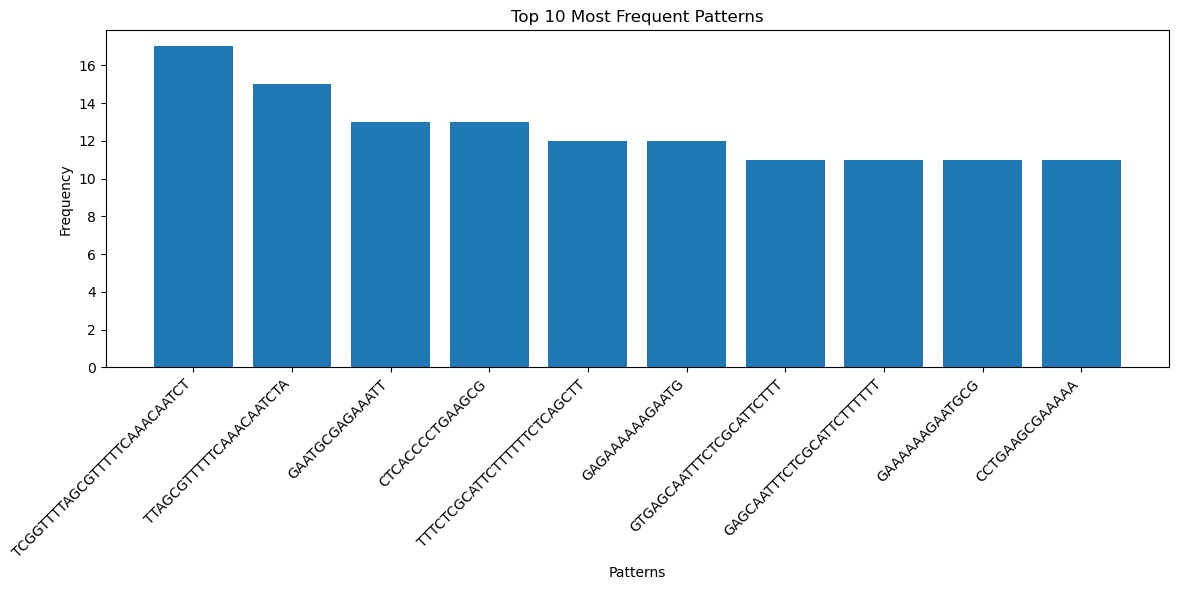

In [57]:
import json
import matplotlib.pyplot as plt

pattern_freq = [(pattern, len(recurring_patterns[pattern])) for pattern in recurring_patterns]

sorted_patterns = sorted(pattern_freq, key=lambda x: x[1], reverse=True)

top_10_patterns = []

for pattern, freq in sorted_patterns:
    is_subpattern_or_superpattern = False
    for top_pattern, _ in top_10_patterns:
        if pattern in top_pattern or top_pattern[1:-1] in pattern:
            is_subpattern_or_superpattern = True
            break
    
    if not is_subpattern_or_superpattern:
        top_10_patterns.append((pattern, freq))
    
    if len(top_10_patterns) == 10:
        break

patterns = [pattern for pattern, _ in top_10_patterns]
frequencies = [freq for _, freq in top_10_patterns]

plt.figure(figsize=(12, 6))
plt.bar(patterns, frequencies)
plt.xlabel('Patterns')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Patterns')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

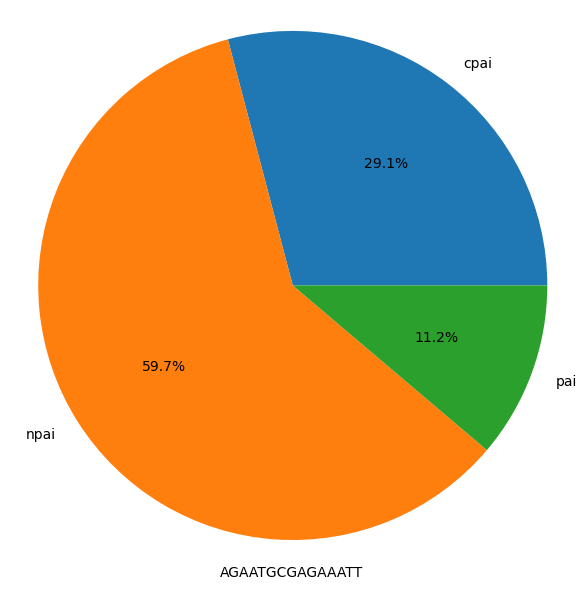

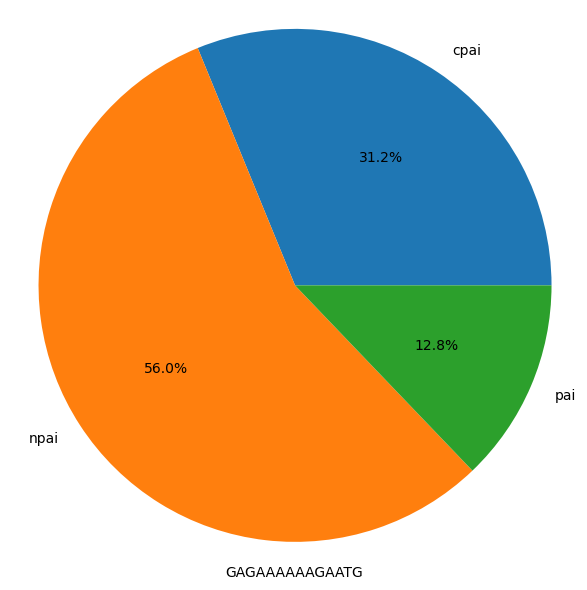

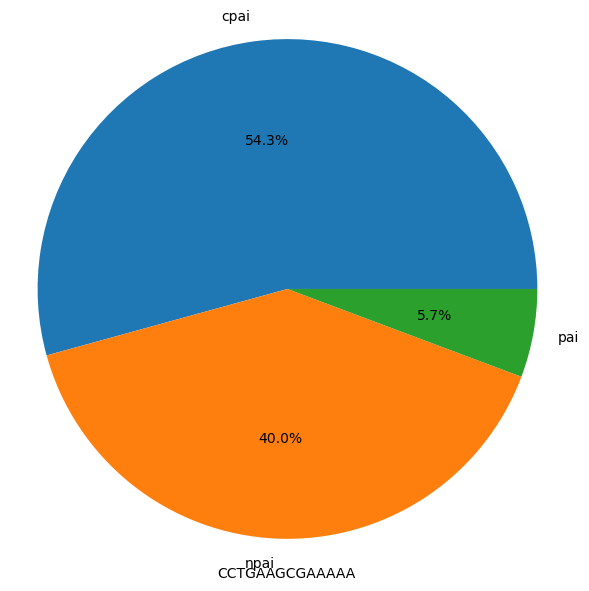

In [6]:
import json
import matplotlib.pyplot as plt

with open('json/recurring_patterns/filtered_recurring_patterns.json', 'r') as file:
    recurring_patterns = json.load(file)

pattern_freq = [(pattern, sum(sum(island_counts.values()) for island_counts in genome_counts.values())) for pattern, genome_counts in recurring_patterns.items()]

sorted_patterns = sorted(pattern_freq, key=lambda x: x[1], reverse=True)

top_3_patterns = []

for pattern, freq in sorted_patterns:
    is_subpattern_or_superpattern = False
    for top_pattern, _ in top_3_patterns:
        if pattern in top_pattern or top_pattern[1:-1] in pattern:
            is_subpattern_or_superpattern = True
            break
    
    if not is_subpattern_or_superpattern:
        top_3_patterns.append((pattern, freq))
    
    if len(top_3_patterns) == 3:
        break

def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 0 else ''

for i, (pattern, _) in enumerate(top_3_patterns, start=1):
    cpai_count = sum(occurrences for genome_counts in recurring_patterns[pattern].values() for island, occurrences in genome_counts.items() if 'cpai' in island)
    npai_count = sum(occurrences for genome_counts in recurring_patterns[pattern].values() for island, occurrences in genome_counts.items() if 'npai' in island)
    pai_count = sum(occurrences for genome_counts in recurring_patterns[pattern].values() for island, occurrences in genome_counts.items() if 'pai' in island and 'cpai' not in island and 'npai' not in island)

    labels = ['cpai', 'npai', 'pai']
    sizes = [cpai_count, npai_count, pai_count]

    labels = [label for label, size in zip(labels, sizes) if size > 0]
    sizes = [size for size in sizes if size > 0]

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct=autopct_format)
    plt.axis('equal')
    plt.xlabel(pattern)
    plt.tight_layout()
    plt.show()

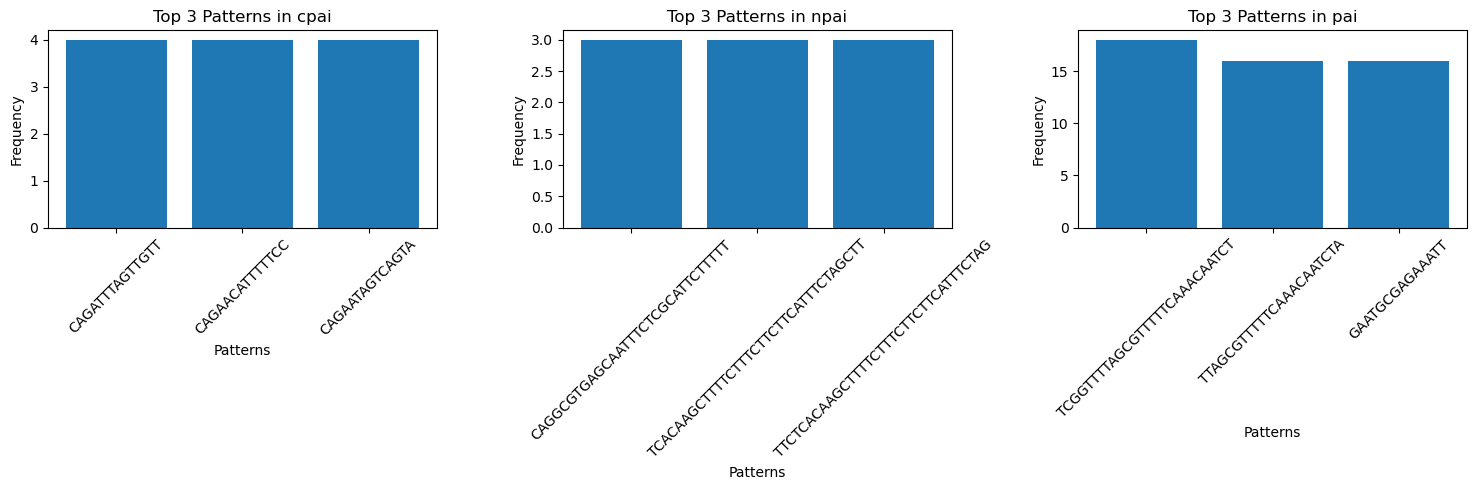

In [5]:
import json
import matplotlib.pyplot as plt

def is_pattern_specific_to_class(pattern, class_name):
    for genome_counts in recurring_patterns[pattern].values():
        for island in genome_counts.keys():
            if class_name not in island:
                return False
    return True

def get_pattern_frequency(pattern, class_name):
    frequency = sum(len(genome_counts) for genome_counts in recurring_patterns[pattern].values() if is_pattern_specific_to_class(pattern, class_name))
    return frequency

def get_top_patterns_per_class(class_name):
    pattern_freq = [(pattern, get_pattern_frequency(pattern, class_name)) for pattern in recurring_patterns if is_pattern_specific_to_class(pattern, class_name)]
    
    sorted_patterns = sorted(pattern_freq, key=lambda x: x[1], reverse=True)
    
    top_3_patterns = []
    
    for pattern, freq in sorted_patterns:
        is_subpattern_or_superpattern = False
        for top_pattern, _ in top_3_patterns:
            if pattern in top_pattern or top_pattern[1:-1] in pattern:
                is_subpattern_or_superpattern = True
                break
        
        if not is_subpattern_or_superpattern:
            top_3_patterns.append((pattern, freq))
        
        if len(top_3_patterns) == 3:
            break
    
    return top_3_patterns

classes = ['cpai', 'npai', 'pai']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, class_name in enumerate(classes):
    top_3_patterns = get_top_patterns_per_class(class_name)
    
    patterns = [pattern for pattern, _ in top_3_patterns]
    frequencies = [freq for _, freq in top_3_patterns]
    
    axs[i].bar(patterns, frequencies)
    axs[i].set_title(f'Top 3 Patterns in {class_name}')
    axs[i].set_xlabel('Patterns')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()